# Simulate free associations

**Information**

The primary advantages of using free associations in psychological research include the ease of capturing spontaneous, unfiltered responses that offer insights into participants' natural thought processes. This method allows for exploring individual heterogeneity and minimizes researcher bias by reducing demand characteristics. It is scalable, making it suitable for large sample sizes, and reveals lay persons understandings of key constructs. The R package `associatoR` facilitates the analysis of free association data, offering tools for data processing, embedding, clustering, and visualization to explore mental representations using natural language processing techniques.

he R package `associatoR` was developed by Samuel Aeschbach, see: https://github.com/samuelae/associatoR

Remark: Work published under the **GNU General Public License Version 3** (GPLv3), published on June 29, 2007, allows users to freely use, modify, and distribute software.

*** 
**Background information**

* The idea of generating 5 responses for a single cue is, for example, implemented in the "Word Association Study": https://smallworldofwords.org/en/introduction
    + and can be used to get, for example, the semantic representation of risk: Wulff, D. U., & Mata, R. (2022). On the semantic representation of risk. Science Advances, 8(27). https://doi.org/10.1126/sciadv.abm1883

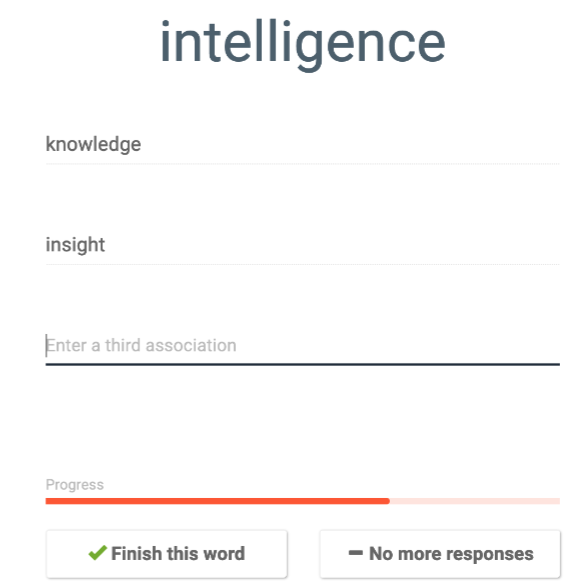

* Possible extension: such associations could be enriched by emotional ratings, as done in the "Affective Imagery Technique"
    + Leiserowitz, A. A. (2005). American Risk Perceptions: Is Climate Change Dangerous? Risk Analysis, 25(6), 1433–1442. https://doi.org/10.1111/j.1540-6261.2005.00690.x

***
**Coding sources**

* To create associations the `meta-llama/Meta-Llama-3-70B-Instruct` is applied, see model page: https://huggingface.co/meta-llama/Meta-Llama-3-70B-Instruct
    + Hugging Face documentation: https://huggingface.co/docs/transformers/main/en/model_doc/llama3



***
**Aim of the code template**

(a) Create word associations and (b) analyze the data using the developed R package (see "analyze generated data" folder). 

# Create word associations - single run

## Environment Setup

Load necessary libraries:

In [1]:
from langchain_core.prompts import ChatPromptTemplate
from openai import OpenAI
import huggingface_hub

from collections import Counter
from huggingface_hub import InferenceClient
import pandas as pd

import re # regular expressions

## Get API key(s)

In [2]:
import os
import sys

# Assuming 'src' is one level down (in the current directory or a subdirectory)
path_to_src = os.path.join('../..','src')  # Moves one level down to 'src' folder

# Add the path to sys.path
sys.path.append(path_to_src)

# Now you can import your API_key module
import API_key as key

## Prompt to create and store word associations

Remark:
It appears that large language models (LLMs) are inherently optimized to avoid redundancy, as they are often trained to treat repetition as undesirable in most natural language generation tasks. Consequently, even when prompted to allow repetition, the model may actively avoid repeating associations. However, in our use case, repetition is essential. To address this, the prompt has been explicitly designed to make repetition mandatory, and an example is provided to clarify the expected output. This ensures the model consistently includes repeated associations where relevant.

In [3]:
system_template = """
<Context>
You are an AI designed to generate associations to specific cues, reflecting the typical thoughts, ideas, and perceptions of five independent adults.
Your task is to ensure that the associations are representative of the societal views and attitudes of these five persons.
</Context>

<Task>
Generate five lists of associations based on the given cue word, whereby each list should contain five associations.
Each list must represent associations to the cue word, and **it is important that important associations are repeated across different lists**.
In particular,repeated association **must appear in at least two lists, and it can appear in all five lists** if it is highly relevant to the cue word.

Here is an example format with some associations repeated across lists:

association 1, association 2, association 3, association 4, association 5;  
association 1, association 3, association 6, association 4, association 5;  
association 2, association 4, association 7, association 3, association 1;  
association 5, association 1, association 2, association 3, association 6;  
association 3, association 1, association 5, association 7, association 4;

Provide the output in the same format, with each list of associations separated by a semicolon (\;):
</Task>
"""



user_template = """
Cue word: {cue_word}
"""


user_template = ChatPromptTemplate.from_messages(
    [("user", user_template)]
)
print("user_template:", user_template)

user_template_invoked = user_template.invoke({"cue_word": "overweight"})
print("user_template_invoked:", user_template_invoked)

user_template: input_variables=['cue_word'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['cue_word'], template='\nCue word: {cue_word}\n'))]
user_template_invoked: messages=[HumanMessage(content='\nCue word: overweight\n')]


## Code to create and store word associations (single run)

**Technical Considerations:**

When querying the API, outputs are automatically cached if the inputs are identical. This applies to our case, as explained in the documentation: https://huggingface.co/docs/api-inference/parameters

> To bypass caching and ensure fresh results for each query, it’s necessary to define the header: `"x-use-cache": "false"`.

In [4]:
# Initialize the client (assuming the client and API key are already set up)
client = InferenceClient(headers={"X-use-cache": "false"}, token=key.hugging_api_key)


# Feed prompts into model, define hyperparameters
chat_completion = client.chat_completion(
    messages=[
        {"role": "system", "content": system_template},
        {"role": "user", "content": user_template_invoked.messages[0].content}
        ],
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    temperature=0.5,
    stream=False
)

In [5]:
message_content = chat_completion.choices[0].message.content

# Split the string after each occurrence of ";"
split_arrays = message_content.split(';')

# remove whitespace from the split arrays
split_arrays = [arr.strip() for arr in split_arrays]

# Print the split arrays
list_of_lists = []
for i, arr in enumerate(split_arrays):
    if i < 5:
        print(f"Person {i+1}: {arr}")
        list_of_lists.append(arr.strip().split(', '))
    
print("list_of_lists:", list_of_lists)

Person 1: obesity, health risks, diet, exercise, weight loss
Person 2: obesity, diet, weight loss, exercise, health risks
Person 3: weight loss, exercise, diet, health risks, self-esteem
Person 4: health risks, obesity, weight loss, diet, exercise
Person 5: diet, exercise, weight loss, obesity, self-esteem
list_of_lists: [['obesity', 'health risks', 'diet', 'exercise', 'weight loss'], ['obesity', 'diet', 'weight loss', 'exercise', 'health risks'], ['weight loss', 'exercise', 'diet', 'health risks', 'self-esteem'], ['health risks', 'obesity', 'weight loss', 'diet', 'exercise'], ['diet', 'exercise', 'weight loss', 'obesity', 'self-esteem']]


In [6]:
print(len(list_of_lists))
print(len(list_of_lists) * 5)
print(list_of_lists[1][0])

5
25
obesity


Check if some associations have been repeated:

In [7]:
# Flatten the list of lists into a single list and convert each word to lowercase
flattened_list = [word.lower() for sublist in list_of_lists for word in sublist]

# Count occurrences of each word
word_counts = Counter(flattened_list)

# Filter words that appear more than once
repeated_words = {word: count for word, count in word_counts.items() if count > 1}

# Print the repeated words and their counts
print(repeated_words)

{'obesity': 4, 'health risks': 4, 'diet': 5, 'exercise': 5, 'weight loss': 5, 'self-esteem': 2}


# Word Association Generation - Process X Cues to Produce Y Responses

The following code generates word associations by processing a specified number of cues (X, 4 in our case) and generating a corresponding set of output responses (Y). It can be enhanced with independent variables (IV) that account for various cognitive and demographic perspectives, such as:

- Typical thoughts, ideas, and perceptions of a **child versus an adult**; resulting in 4*2*10 (25 responses each) = 80 API calls
- Typical thoughts, ideas, and perceptions of a **female / male X adult / child**; resulting in 4*2*2*10 (25 responses each) = 160 API calls

These variables allow for more personalized and context-aware word associations, reflecting differences in cognition across age, gender, and other demographic factors to test hypotheses regarding:

**Gender differences**:
*Possible hypothesis: There could be gender-based differences in cognitive associations due to societal roles, expectations, or differences in lived experiences. For example, males and females may have different associations with specific cues because of how they are socialized to perceive the world.*

**Differences depending on own weight**:
*Possible hypothesis: An individual's body weight could influence cognitive associations, particularly in contexts like body image, self-esteem, and food-related cues. People with higher or lower body weight might have distinct reactions to certain words due to personal experiences with societal attitudes toward weight.*

## Adjust system prompt to create and store word associations

Our aim is to introduce some dependency in the associations, because in our "real-life" study one person provides associations regarding four different cue words: "overweight", "underweight", "normal weight", "muscular".


The prompt is in German, you could easily translate it to any language using DeepL or ChatGPT.

In [8]:
system_template = """
<Kontext>
Du bist eine KI, die dafür entwickelt wurde, Assoziationen zu spezifischen Hinweisworten zu generieren, die die typischen Gedanken, Ideen und Wahrnehmungen von einem Erwachsenen widerspiegeln.
Deine Aufgabe ist es sicherzustellen, dass die Assoziationen repräsentativ für die gesellschaftlichen Ansichten und Einstellungen dieser Person ist.
</Kontext>

<Aufgabe>
Erstelle vier Listen von Assoziationen zu den gegebenen Hinweisworten, wobei jede Liste fünf Assoziationen enthalten soll.
Jede Liste muss Assoziationen zum jeweiligen Hinweisworte darstellen.

Hier ist ein Beispiel-Format mit einigen wiederholten Assoziationen über die Listen hinweg:

1. Hinweiswort: [association 1, association 2, association 3, association 4, association 5];
2. Hinweiswort: [association 1, association 2, association 3, association 4, association 5];
3. Hinweiswort: [association 1, association 2, association 3, association 4, association 5];
4. Hinweiswort: [association 1, association 2, association 3, association 4, association 5];

Gib das Ergebnis im gleichen Format aus, wobei jede Liste von Assoziationen durch ein Semikolon (\;) getrennt ist:
</Aufgabe>
"""

user_template = """
1. Hinweiswort: {cue_word1}
2. Hinweiswort: {cue_word2}
3. Hinweiswort: {cue_word3}
4. Hinweiswort: {cue_word4}
"""


user_template = ChatPromptTemplate.from_messages(
    [("user", user_template)]
)
print("user_template:", user_template)

user_template_invoked = user_template.invoke({"cue_word1": "übergewichtig", "cue_word2": "untergewichtig", "cue_word3": "normalgewichtig", "cue_word4": "muskulös"})
print("user_template_invoked:", user_template_invoked)

user_template: input_variables=['cue_word1', 'cue_word2', 'cue_word3', 'cue_word4'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['cue_word1', 'cue_word2', 'cue_word3', 'cue_word4'], template='\n1. Hinweiswort: {cue_word1}\n2. Hinweiswort: {cue_word2}\n3. Hinweiswort: {cue_word3}\n4. Hinweiswort: {cue_word4}\n'))]
user_template_invoked: messages=[HumanMessage(content='\n1. Hinweiswort: übergewichtig\n2. Hinweiswort: untergewichtig\n3. Hinweiswort: normalgewichtig\n4. Hinweiswort: muskulös\n')]


## Code to create and store word associations (single run)

In [151]:
# Initialize the client (assuming the client and API key are already set up)
client = InferenceClient(headers={"X-use-cache": "false"}, token=key.hugging_api_key)


# Feed prompts into model, define hyperparameters
chat_completion = client.chat_completion(
    messages=[
        {"role": "system", "content": system_template},
        {"role": "user", "content": user_template_invoked.messages[0].content}
        ],
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    temperature=0.6,
    stream=False,
    max_tokens=1400
)

In [169]:
message_content = chat_completion.choices[0].message.content
print("message_content:", message_content, "\n")

# Regular expression to find content inside square brackets
arrays = re.findall(r'\[(.*?)\]', message_content)
# Split the arrays into lists of words
split_arrays = [array.strip().split(', ') for array in arrays]

list_of_lists = []
# Display the extracted arrays
for i, array in enumerate(split_arrays):
    print(f"Cue {i+1}: {array}")
    list_of_lists.append(array)

print("list_of_lists:", list_of_lists, "\n")
len(list_of_lists)

message_content: 1. Hinweiswort: übergewichtig; [Gesundheitsrisiken, Übergewicht, Fettleibigkeit, Diät, Ernährungsumstellung];
2. Hinweiswort: untergewichtig; [Mangelernährung, Schwäche, Gesundheitsprobleme, Untergewicht, Ernährungsberatung];
3. Hinweiswort: normalgewichtig; [Gesundheit, Wohlbefinden, Idealgewicht, Fitness, Ausgeglichenheit];
4. Hinweiswort: muskulös; [Krafttraining, Fitnessstudio, Sport, Stärke, Attraktivität]; 

Cue 1: ['Gesundheitsrisiken', 'Übergewicht', 'Fettleibigkeit', 'Diät', 'Ernährungsumstellung']
Cue 2: ['Mangelernährung', 'Schwäche', 'Gesundheitsprobleme', 'Untergewicht', 'Ernährungsberatung']
Cue 3: ['Gesundheit', 'Wohlbefinden', 'Idealgewicht', 'Fitness', 'Ausgeglichenheit']
Cue 4: ['Krafttraining', 'Fitnessstudio', 'Sport', 'Stärke', 'Attraktivität']
list_of_lists: [['Gesundheitsrisiken', 'Übergewicht', 'Fettleibigkeit', 'Diät', 'Ernährungsumstellung'], ['Mangelernährung', 'Schwäche', 'Gesundheitsprobleme', 'Untergewicht', 'Ernährungsberatung'], ['Gesund

4

## Code to create and store word associations (multiple runs)

In [170]:
# manually define vector of cue words
vec_cues = ["übergewichtig", "untergewichtig", "normalgewichtig", "muskulös"]


# Initialize the client (assuming the client and API key are already set up)
client = InferenceClient(headers={"X-use-cache": "false"}, token=key.hugging_api_key)


for index, _ in enumerate(range(10)):
    # Feed prompts into model, define hyperparameters
    chat_completion = client.chat_completion(
        messages=[
            {"role": "system", "content": system_template},
            {"role": "user", "content": user_template_invoked.messages[0].content}
            ],
        model="meta-llama/Meta-Llama-3.1-70B-Instruct",
        temperature=0.6,
        stream=False,
        max_tokens=1400
    )
    
    
    message_content = chat_completion.choices[0].message.content
    
    
    # Regular expression to find content inside square brackets
    arrays = re.findall(r'\[(.*?)\]', message_content)
    # Split the arrays into lists of words
    split_arrays = [array.strip().split(', ') for array in arrays]

    list_of_lists = []
    # Display the extracted arrays
    for i, array in enumerate(split_arrays):
        #print(f"Cue {i+1}: {array}")
        list_of_lists.append(array)
        
    # Print or process the resulting list_of_lists
    print(f"Processed list iteration {index + 1}: {list_of_lists}")
    
    # Save the list of lists to a file
    # # > Transform into long format with an ID, independent variables, cue word, response and position
    long_data = []
    for idx, sublist in enumerate(list_of_lists, start=0):
        for pos, item in enumerate(sublist, start=0):
            long_data.append(["Run_" + str(index + 1) + "_" + str(idx + 1), "none", "adult", vec_cues[idx], item, pos + 1])
            df_long_internal = pd.DataFrame(long_data, columns=["participant_id", "gender", "agegroup", "cue", "response", "response_position"])
            
    # place the if block inside the loop
    if index == 0:
        print("First iteration")
        df_long = df_long_internal
    else:
        print("Not first iteration")
        df_long = pd.concat([df_long, df_long_internal])


# save the resulting data frame to a file
len(df_long)
df_long.to_excel("generated data/word_associations.xlsx", index=False)

Processed list iteration 1: [['Gesundheitsrisiken', 'Übergewicht', 'Diät', 'Fettleibigkeit', 'Ernährungsumstellung'], ['Mangelernährung', 'Schwäche', 'Gesundheitsprobleme', 'Untergewicht', 'Ernährungszusatz'], ['Gesundheit', 'Wohlbefinden', 'Idealgewicht', 'Fitness', 'Ausgeglichenheit'], ['Kraft', 'Fitnessstudio', 'Muskelaufbau', 'Athletik', 'Sportler']]
First iteration
Processed list iteration 2: [['Gesundheitsrisiken', 'Diät', 'Übergewicht', 'Fettleibigkeit', 'Selbstbewusstseinsprobleme'], ['Mangelernährung', 'Gesundheitsprobleme', 'Schwäche', 'Untergewicht', 'Erschöpfung'], ['Gesundheit', 'Fitness', 'Wohlbefinden', 'Idealgewicht', 'Selbstsicherheit'], ['Kraft', 'Fitness', 'Sport', 'Attraktivität', 'Selbstbewusstsein']]
Not first iteration
